  0%|          | 0/500 [00:00<?, ?it/s]

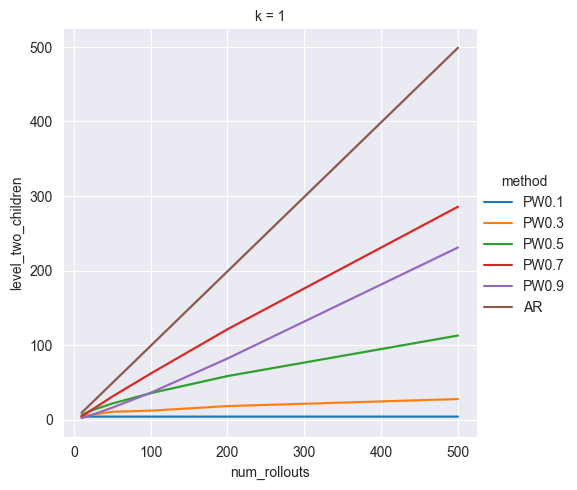

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import seaborn as sns
from torch.nn.utils import spectral_norm
from collections import defaultdict
from tqdm.notebook import tqdm

class GMMSampler:
  def __init__(self, n_components, dim):
    self.categorical = np.random.dirichlet(np.ones((n_components,)))
    self.means = np.random.normal(scale=1, size=(n_components, dim))
    tmp = np.random.normal(scale=0.1, size=(n_components, dim, dim))
    self.var = np.einsum('...ij,...ik->...jk', tmp, tmp)
    self.indices = np.arange(n_components)

  def sample(self, n_samples):
    events = np.random.choice(self.indices, p=self.categorical, size=n_samples)
    unique, counts = np.unique(events, return_counts=True)
    samples = []
    for i, n_events in zip(unique, counts):
      if n_events == 0:
        continue
      samples.append(np.random.multivariate_normal(self.means[i], self.var[i], size=n_events))
    return np.concatenate(samples)

class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim=50):
    super().__init__()
    self.input_dim = input_dim
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = self.fc1(x)
    return 10 * self.fc2(x)


class SinusoidalModel(nn.Module):
  def __init__(self, input_dim, hidden_dim=50):
    super().__init__()
    self.input_dim = input_dim
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = torch.sin(self.fc1(x))
    return 10 * self.fc2(x)


class ReluModel(nn.Module):
  def __init__(self, input_dim, hidden_dim=50):
    super().__init__()
    self.input_dim = input_dim
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    return 10 * self.fc2(x)


class SigmoidModel(nn.Module):
  def __init__(self, input_dim, hidden_dim=50):
    super().__init__()
    self.input_dim = input_dim
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    return 10 * self.fc2(x)


class MRP:
  def __init__(self, sampler, model, n_v0_samples=5, s0_var=0.01):
    self.sampler = sampler
    self.model = model
    self.v0 = model(torch.from_numpy(sampler.sample(n_v0_samples)).float()).mean().item()
    self.s0_var = s0_var

  def sample(self, s=None, n_samples=1):
    if s is None:
      return np.random.normal(0, 0.01, size=(n_samples,))
    return s + self.sampler.sample(n_samples)

  def evaluate_s0(self, s0):
    return self.v0 + s0

  def evaluate_s1(self, s1):
    return self.model(torch.from_numpy(s1).float()).detach().numpy()


class PW:
  def __init__(self, exp, factor=1):
    self.exp = exp
    self.n_visits = defaultdict(int)
    self.children = defaultdict(list)
    self.factor = factor

  def should_expand(self, state):
    return len(self.children[state]) <= self.factor * self.n_visits[state] ** self.exp

  def sample_from(self, state, mrp):
    if state is None:
      self.n_visits[state] += 1
    if self.should_expand(state):
      if state is None:
        next_state = mrp.sample().flatten()
      else:
        next_state = mrp.sample(np.array(state[1])).flatten()
      next_state = (state, tuple(next_state))
      self.children[state].append(next_state)
      self.n_visits[next_state] += 1
      return next_state, True
    else:
      next_state = self.children[state][np.random.choice(np.arange(len(self.children[state])))]
      self.n_visits[next_state] += 1
      return next_state, False


class AR:
  def __init__(self, exp, factor):
    self.exp = exp
    self.factor = factor
    self.n_visits = defaultdict(int)
    self.children = defaultdict(list)

  def sample_from(self, state, sampler):
    if state is None:
      self.n_visits[state] += 1
      new_state = mrp.sample().flatten()
    else:
      new_state = mrp.sample(np.array(state[1])).flatten()
    distances = {child: np.sqrt(((np.array(child[1]) - new_state) ** 2).sum()) for child in self.children[state]}
    if len(distances) == 0:
      next_state = (state, tuple(new_state))
      self.children[state].append(next_state)
      self.n_visits[next_state] += 1
      return next_state, True
    nn = min(distances, key=distances.get)
    dist = distances[nn]
    if dist < self.factor * (self.n_visits[nn] ** (- self.exp)):
      next_state = nn
      self.n_visits[next_state] += 1
      return next_state, False
    next_state = (state, tuple(new_state))
    self.children[state].append(next_state)
    self.n_visits[next_state] += 1
    return next_state, True
    

def evaluate(method, mrp, n_rollouts):
  vals = []
  for t in range(n_rollouts):
    s_init = None
    s0, new_state = method.sample_from(s_init, mrp)
    if new_state:
      vals.append(mrp.evaluate_s0(np.array(s0[1])))
      continue
    s1, new_state = method.sample_from(s0, mrp)
    vals.append(mrp.evaluate_s1(np.array(s1[1])))
  return np.mean(vals)

def evaluate_empirical(sampler, model, supp_card):
  points = sampler.sample(supp_card)
  with torch.no_grad():
    vals = model(torch.from_numpy(points).float()).squeeze().numpy()
  return vals.mean()
  
n_components = 10
dim = 30
ground_truth_n_samples = 100_000
n_trials = 500
num_rollouts = [10, 20, 50, 100, 200, 500]
pw_factors = [1]#[0.5, 1, 2, 5, 10, 20, 50, 100] 
pw_exponents = [0.1, 0.3, 0.5, 0.7, 0.9]
ar_factor = 1
ar_exponent = 0.1

vfs = {'Relu': ReluModel}

df = {'method': [], 'value_error': [], 'num_rollouts': [], 'vf': [], 'level_one_children': [], 'level_two_children': [], 'k': [], 'exp': []}
for trial in tqdm(range(n_trials)):
  sampler = GMMSampler(n_components, dim)
  for vf_name, vf_class in vfs.items():
    model = vf_class(dim)
    mrp = MRP(sampler, model)
    ground_truth = evaluate_empirical(sampler, model, ground_truth_n_samples)
    for nr in num_rollouts:
      for e in pw_exponents:
        for k in pw_factors:
          df['method'].append(f'PW{e}')
          df['exp'].append(e)
          df['k'].append(k)
          df['num_rollouts'].append(nr)
          alg = PW(e, k)
          df['value_error'].append(abs(evaluate(alg, mrp, nr) - ground_truth))
          df['level_one_children'].append(len(alg.children[None]))
          df['level_two_children'].append(sum([len(val) for key, val in alg.children.items() if key is not None]))
          df['vf'].append(vf_name)
      df['method'].append('AR')
      df['num_rollouts'].append(nr)
      alg = AR(ar_exponent, ar_factor)
      df['exp'].append(ar_exponent)
      df['k'].append(ar_factor)
      df['value_error'].append(abs(evaluate(alg, mrp, nr) - ground_truth))
      df['level_one_children'].append(len(alg.children[None]))
      df['level_two_children'].append(sum([len(val) for key, val in alg.children.items() if key is not None]))
      df['vf'].append(vf_name)
  df_ = pd.DataFrame(df)
  plt.close()
  df_.to_pickle('df.pkl')
  df_.to_csv('df.csv')
  df_['value_error'] = df_['value_error'].astype(float)
df_ = pd.read_csv("df.csv")
ar_rows = df_[df_['method'] == 'AR']

# Crea un nuovo DataFrame vuoto per memorizzare le nuove righe
new_rows = pd.DataFrame()

# Duplica le righe sostituendo il valore di 'k' con i valori in k_values
for k in pw_factors:
    temp = ar_rows.copy()
    temp['k'] = k
    new_rows = pd.concat([new_rows, temp])

# Aggiungi le nuove righe al DataFrame originale
df_ = pd.concat([df_, new_rows], ignore_index=True)


ax = sns.relplot(data=df_, x='num_rollouts', y='value_error', hue='method', kind='line', col='k', facet_kws={'sharey': False, 'sharex': True})
ax.set(yscale="log")
plt.savefig(f'mrp_full.png')
plt.savefig('mrp.pdf')
plt.close()
ax = sns.relplot(data=df_, x='num_rollouts', y='level_one_children', hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
plt.savefig('level_one_full.png')
plt.savefig('level_one.pdf')
plt.close()
sns.relplot(data=df_, x='num_rollouts', y='level_two_children', hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
plt.savefig('level_two_full.png')
plt.savefig('level_two.pdf')